In [1]:
import pandas as pd
%pylab inline

import scipy.stats as stats
from cliffs_delta import cliffs_delta

Populating the interactive namespace from numpy and matplotlib


# Preparation & Clean

In [2]:
season = pd.read_csv('../19-20 Orchestral Data.csv', na_values=999)

season.columns = season.columns.str.lower()
season.replace(' ', np.nan, inplace=True)

# style: composer/arranger
season.loc[season['composer'] == 'Beethoven arr. Mahler', 'composer'] = 'Beethoven/Mahler'
season.loc[season['composer'] == 'Pärt', 'composer'] = 'Pärt, Arvo'
season.loc[season['composer'] == 'Custer (arr.)', 'composer'] = 'Custer'
season.loc[season['composer'] == 'Tchaikovsky (arr. J. Montgomery)', 'composer'] = 'Tchaikovsky/J. Montgomery'

# add arranger column, if available
comp_arr = season['composer'].str.split('/', expand=True)
season[['composer', 'arranger']] = comp_arr

# composers: Various, Unknown
season.loc[season['comp.code'].isna() | season['composer'].str.contains('Unknown'), ['comp.code', 'comp.live']] = np.nan

In [3]:
season.head()

,ensemble,composer,work,comp.code,arr.code,comp.live,arr.live,lao.group,arranger
0,Buffalo,Unknown,(cello concerto),NaN,NaN,NaN,NaN,2,None
1,Cape,Unknown,(Cello Concerto),NaN,NaN,NaN,NaN,4,None
2,Omaha,Unknown,(Clarinet Concerto),NaN,NaN,NaN,NaN,2,None
3,Omaha,Unknown,2 more works (est.),NaN,NaN,NaN,NaN,2,None
4,Omaha,Unknown,2 more works (est.),NaN,NaN,NaN,NaN,2,None


# Analysis

## General

In [4]:
season.isna().sum()

ensemble        0
composer        0
work            0
comp.code      10
arr.code     4028
comp.live      10
arr.live     4028
lao.group       0
arranger     4026
dtype: int64

In [5]:
season[season['comp.code'].isna()]

,ensemble,composer,work,comp.code,arr.code,comp.live,arr.live,lao.group,arranger
0,Buffalo,Unknown,(cello concerto),NaN,NaN,NaN,NaN,2,None
1,Cape,Unknown,(Cello Concerto),NaN,NaN,NaN,NaN,4,None
2,Omaha,Unknown,(Clarinet Concerto),NaN,NaN,NaN,NaN,2,None
3,Omaha,Unknown,2 more works (est.),NaN,NaN,NaN,NaN,2,None
4,Omaha,Unknown,2 more works (est.),NaN,NaN,NaN,NaN,2,None
5,Florida,Unknown (competition winner),Unknown,NaN,NaN,NaN,NaN,2,None
4062,Detroit,Various,Yet Another Set of Variations (on a Theme by P...,NaN,NaN,NaN,NaN,1,None
4063,Nashville,Various,Yet Another Set of Variations (on a Theme by P...,NaN,NaN,NaN,NaN,1,None
4064,National Symphony,Various,Yet Another Set of Variations (on a Theme by P...,NaN,NaN,NaN,NaN,1,None
4065,St. Louis,Various,Yet Another Set of Variations (on a Theme by P...,NaN,NaN,NaN,NaN,1,None


### Number of Performances per Ensemble

In [6]:
season['ensemble'].value_counts().describe()

count    120.000000
mean      33.883333
std       20.402333
min       10.000000
25%       19.000000
50%       26.000000
75%       44.000000
max       99.000000
Name: ensemble, dtype: float64

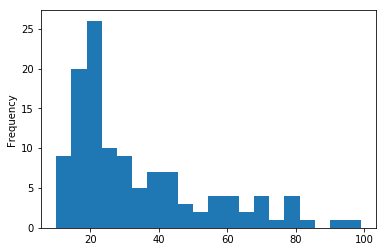

In [7]:
# distribution of number of works performed
season['ensemble'].value_counts().plot.hist(bins=20)

* Only **120** orchestras (out of at least 1224 (2014, from [Wiki](https://en.wikipedia.org/wiki/List_of_symphony_orchestras_in_the_United_States)))
* Range: **10 - 99** works per orchestra, median **26** works

### Most Performed Composers

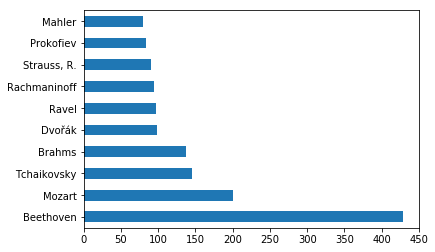

In [8]:
season['composer'].value_counts().head(10).plot.barh()

* Most played composers: **Beethoven**, **Mozart**, **Tchaikovsky**

### Most Performed Type of Work

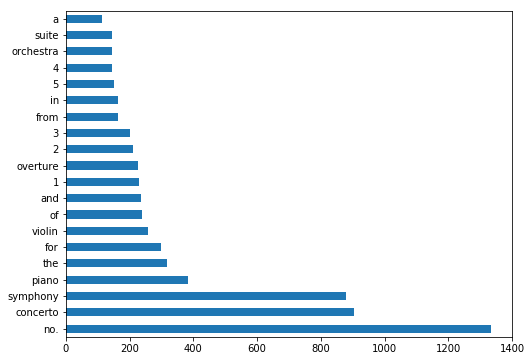

In [9]:
season['work'].str.lower().str.split(expand=True).stack().value_counts().head(20).plot.barh(figsize=(8, 6))

* Most played type of works: concerto, symphony, piano (concerto), violin (concerto), overture, suite
    * **Assumption:** type of work is in the title, not usually true for works by living composers

### Demographics

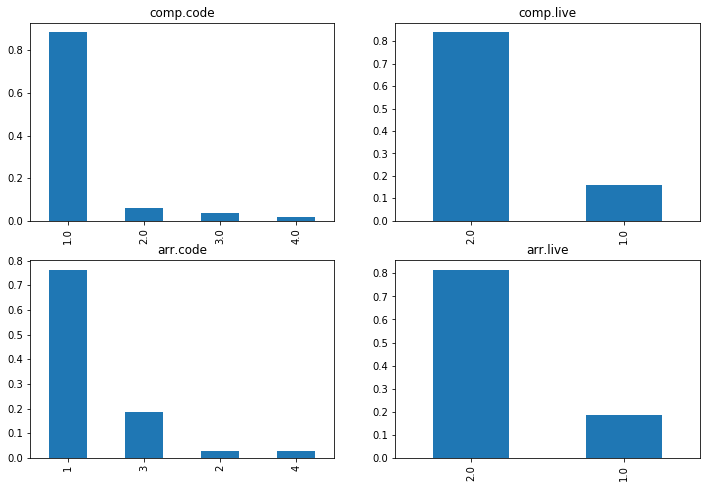

In [10]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

for col, ax in zip(['comp.code', 'comp.live', 'arr.code', 'arr.live'], [ax1, ax2, ax3, ax4]):
    season[col].value_counts(normalize=True).plot.bar(ax=ax)
    ax.set_title(col)

* White male dominates demographics of composers and arrangers, at **80%**
* Most orchestras play works by deceased composers and arrangers, at **80%**

### LAO Group

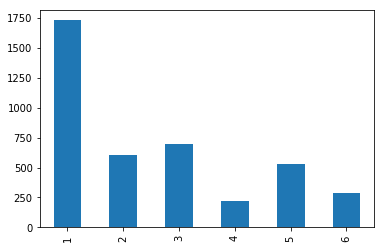

In [11]:
season['lao.group'].value_counts().sort_index().plot.bar()

* LAO group distribution skews heavily towards group 1

### Alternative Grouping: by Number of Performed Works

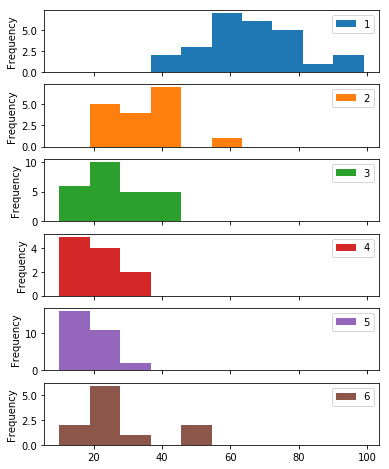

In [12]:
# distributions of performance counts for lao.groups overlap, especially for group 3-6
season.groupby('lao.group')['ensemble'].value_counts().unstack('lao.group').plot.hist(subplots=True, figsize=(6, 8), ylabel=['']);

#### Groupings

* **LAO group**
    * Pros
        * Similar in ???
        * Invariant between seasons due to fixed grouping by LAO
    * Cons
        * Ensembles cannot move between groups
        * Uneven distribution of performed works
        * Multiple groups overlap
* **Quantiles, by number of works**
    * Pros
        * Even number of orchestras per group
    * Cons
        * Varies significantly between seasons regardless of size, budgets, etc.
* **Evenly spaced, by number of works**
    * Pros
        * Assumes similar programming budgets within groups
            * Programming difference more likely due to choice than budgetary constraints
        * Preserves similarity in LAO group
        * Likely invariant between seasons by accounting for upper and lower limit
        * Ensembles move to different group based on number of works performed
    * Cons
        * Uneven distribution, can be extreme

In [13]:
# divide range of number of works into 4 equal groups
bins = pd.cut(season['ensemble'].value_counts(), bins=4, labels=range(4)).reset_index()
bins.columns = ['ensemble', 'bin']

bins.groupby('bin')['ensemble'].unique()

bin
0    [Charlotte, Chautauqua, River Oaks, Eugene, Au...
1    [Houston, Oregon, Indianapolis, Colorado, San ...
2    [Philadelphia, Atlanta, Cleveland, Utah, Dalla...
3    [Chicago, Los Angeles, San Francisco, New York...
Name: ensemble, dtype: object

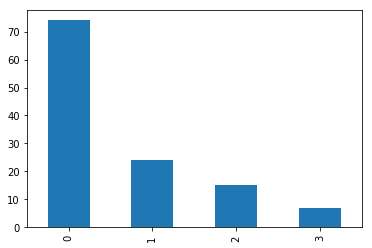

In [14]:
# number of orchestras per bin
bins['bin'].value_counts().sort_index().plot.bar()

In [15]:
season = pd.merge(season, bins, on='ensemble')

## In Detail

### Orchestras Having the Most / Least Performances of Works by Living Composers

In [16]:
top, bottom = lambda df, n: df.head(n), lambda df, n: df.tail(n)

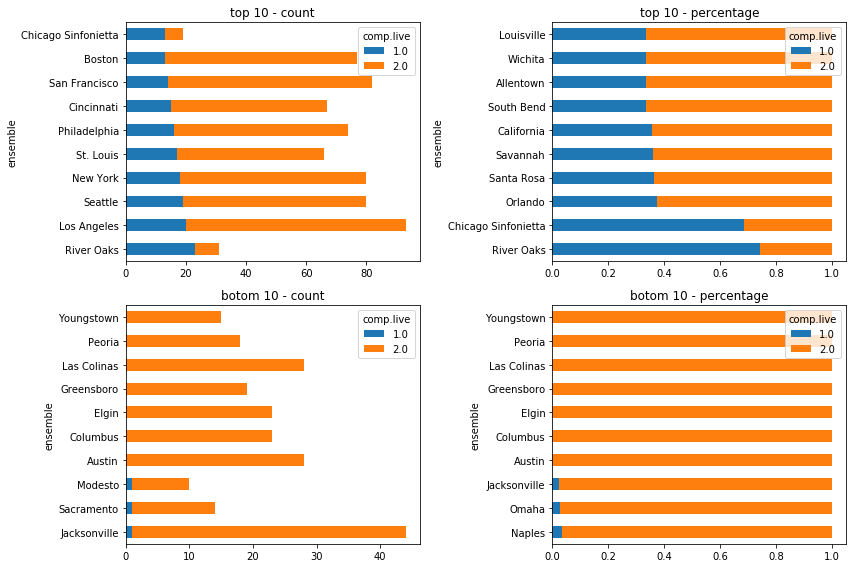

In [17]:
_, axes = plt.subplots(2, 2, figsize=(12, 8))

for sub, sublbl, axes_pair in zip([top, bottom], ['top 10', 'botom 10'], axes):
    for norm, label, ax in zip(range(2), ['count', 'percentage'], axes_pair):
        title = '{} - {}'.format(sublbl, label)
        (sub(season.groupby('ensemble')['comp.live']
             .value_counts(normalize=norm)
             .unstack()
             .sort_values(1, ascending=False), 10)
         .plot.barh(ax=ax, stacked=True, title=title))

plt.tight_layout()

* **Chicago Sinfonetta** and **River Oaks** were only the only orchestras with more than 50% living composers

### Group Having the Most / Least Performances of Works by Living Composers

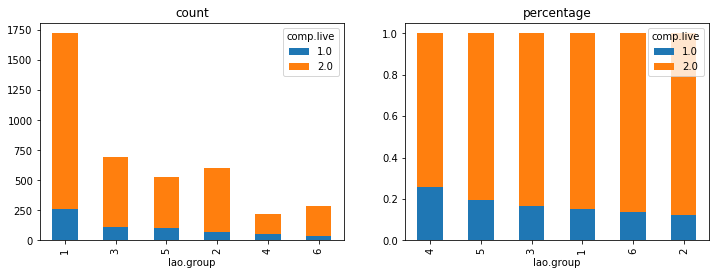

In [18]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

for norm, label, ax in zip(range(2), ['count', 'percentage'], axes):
    (season.groupby('lao.group')['comp.live']
     .value_counts(normalize=norm)
     .unstack()
     .sort_values(1, ascending=False)
     .plot.bar(ax=ax, stacked=True, title=label))

**Note:** The high number of performances highly due to number of orchestras belonging to group 1, uneven distribution of LAO groups

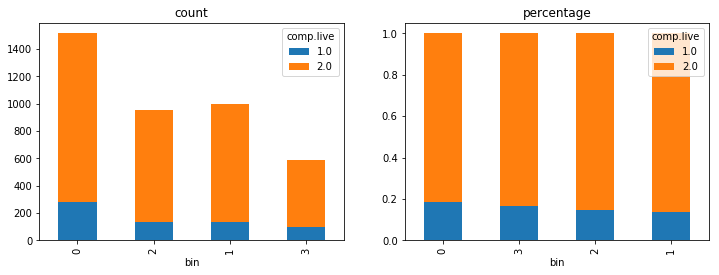

In [19]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

for norm, label, ax in zip(range(2), ['count', 'percentage'], axes):
    (season.groupby('bin')['comp.live']
     .value_counts(normalize=norm)
     .unstack()
     .sort_values(1, ascending=False)
     .plot.bar(ax=ax, stacked=True, title=label))

* By percentage, all bins have about the same percentage of works by living vs. deceased composers, **15-20%**

#### Among the same peer group ...

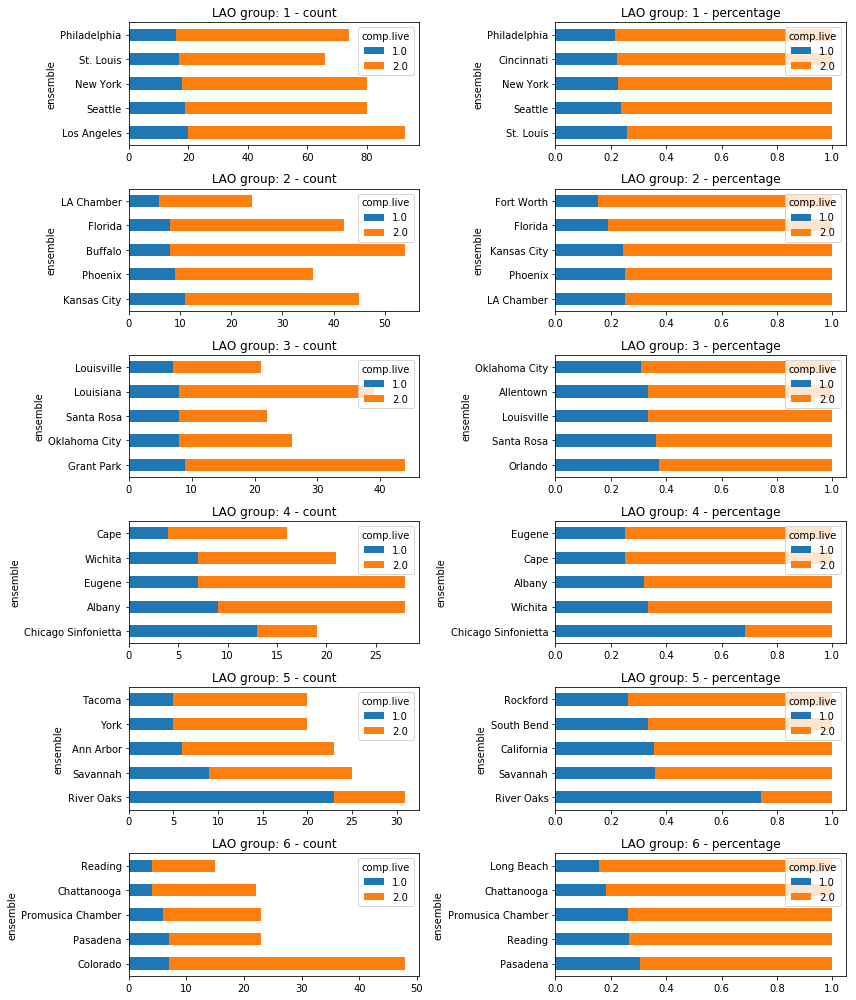

In [20]:
_, axes = plt.subplots(6, 2, figsize=(12, 14))

for group, axes_pair in zip(range(1, 7), axes):
    for norm, label, ax in zip(range(2), ['count', 'percentage'], axes_pair):
        title = 'LAO group: {} - {}'.format(group, label)
        (season.groupby(['lao.group', 'ensemble'])['comp.live']
         .value_counts(normalize=norm)[group, ]
         .unstack('comp.live')
         .sort_values(1, ascending=False)
         .head(5)
         .plot.barh(stacked=True, ax=ax, title=title))
    
plt.tight_layout()

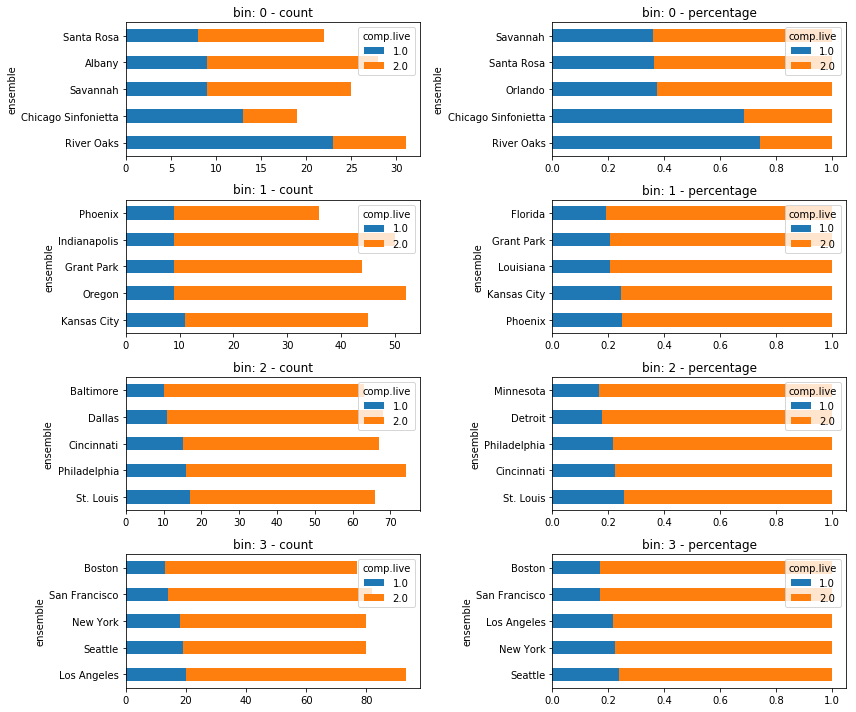

In [21]:
_, axes = plt.subplots(4, 2, figsize=(12, 10))

for group, axes_pair in zip(range(4), axes):
    for norm, label, ax in zip(range(2), ['count', 'percentage'], axes_pair):
        title = 'bin: {} - {}'.format(group, label)
        (season.groupby(['bin', 'ensemble'])['comp.live']
         .value_counts(normalize=norm)[group, ]
         .unstack('comp.live')
         .sort_values(1, ascending=False)
         .head(5)
         .plot.barh(stacked=True, ax=ax, title=title))
    
plt.tight_layout()

### Orchestras Having the Most Performances of Works by Composers of Various Demographics

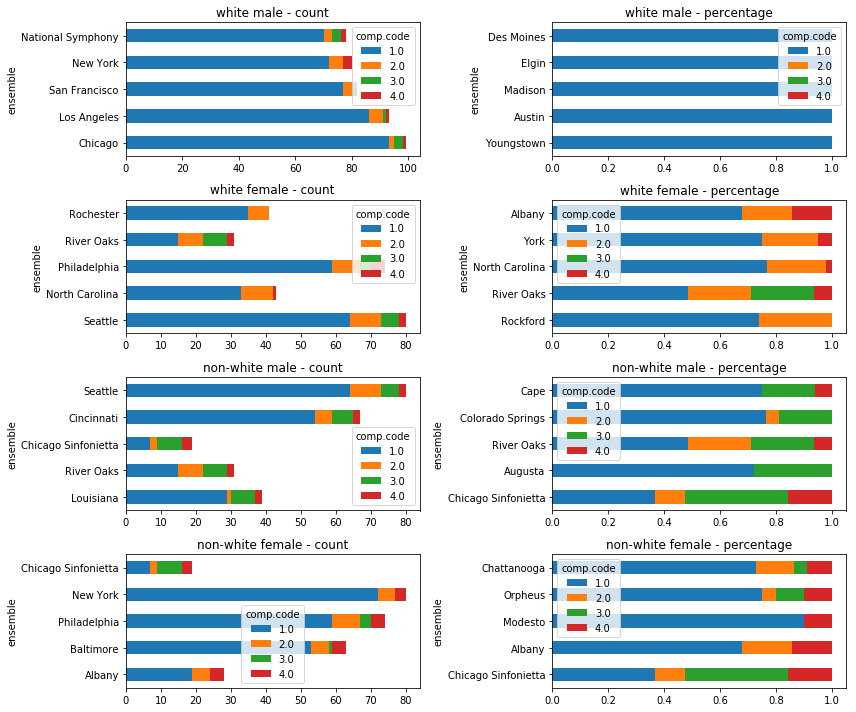

In [22]:
_, axes = plt.subplots(4, 2, figsize=(12, 10))

for code, demo, axes_pair in zip(range(1, 5), ['white male', 'white female', 'non-white male', 'non-white female'], axes):
    for norm, label, ax in zip(range(2), ['count', 'percentage'], axes_pair):
        title = '{} - {}'.format(demo, label)
        (season.groupby('ensemble')['comp.code']
         .value_counts(normalize=norm)
         .unstack()
         .sort_values(code, ascending=False)
         .head(5)
         .plot.barh(stacked=True, ax=ax, title=title))
    
plt.tight_layout()

In [23]:
def demo_counts(demo):
    n = len(demo)
    all_ = ((demo == 0).sum(axis=1) == 0).sum()
    only_wm = ((demo[[2, 3, 4]] != 0).sum(axis=1) == 0).sum()
    more_wm = (demo[1] > (demo[[2, 3, 4]].sum(axis=1))).sum()
    more_w = (demo[[1, 2]].sum(axis=1) > (demo[[3, 4]].sum(axis=1))).sum()
    more_m = (demo[[1, 3]].sum(axis=1) > (demo[[2, 4]].sum(axis=1))).sum()
    
    statements = zip([all_, only_wm, more_wm, more_w, more_m], [
        'play works by all 4 demographics',
        'play works exclusively by white male composers',
        'play more works by white male composers than all underrepresented groups combined',
        'play more works by white composers than non-white composers',
        'play more works by male composers than female composers'
    ])
    
    lines = '\n'.join([
        f'Among \033[1m{n} ({n * 100 / 120:.0f}%)\033[0m ensembles,',
        *[
            f'* \033[1m{count} ({count * 100 / n:.0f}%)\033[0m ' + statement for count, statement in statements
        ]
    ])
    
    return lines

In [24]:
# all orchestras
print(demo_counts(season.groupby('ensemble')['comp.code'].value_counts().unstack().fillna(0)))

Among 120 (100%) ensembles,
* 32 (27%) play works by all 4 demographics
* 12 (10%) play works exclusively by white male composers
* 118 (98%) play more works by white male composers than all underrepresented groups combined
* 119 (99%) play more works by white composers than non-white composers
* 120 (100%) play more works by male composers than female composers


In [25]:
# orchestras playing at least 1 work by living composers
print(demo_counts(season[season['comp.live'] == 1].groupby('ensemble')['comp.code'].value_counts().unstack().fillna(0)))

Among 113 (94%) ensembles,
* 22 (19%) play works by all 4 demographics
* 14 (12%) play works exclusively by white male composers
* 46 (41%) play more works by white male composers than all underrepresented groups combined
* 94 (83%) play more works by white composers than non-white composers
* 73 (65%) play more works by male composers than female composers


### Composers Featured the Most, By Living Status and Demographics

In [26]:
season.groupby('comp.live')['composer'].apply(lambda comp: comp.value_counts().head())

comp.live                      
1.0        Adams, John              27
           Higdon, Jennifer         27
           Clyne, Anna              26
           Mazzoli, Missy           16
           Frank, Gabriela Lena     13
2.0        Beethoven               428
           Mozart                  201
           Tchaikovsky             146
           Brahms                  137
           Dvořák                   98
Name: composer, dtype: int64

In [27]:
# breakdown into demographics, top 5 per group
season.groupby(['comp.live', 'comp.code'])['composer'].apply(lambda comp: comp.value_counts().head())

comp.live  comp.code                      
1.0        1.0        Adams, John              27
                      Bates, Mason             12
                      Norman, Andrew           12
                      Adès, Thomas             10
                      Williams, John            9
           2.0        Higdon, Jennifer         27
                      Clyne, Anna              26
                      Mazzoli, Missy           16
                      Shaw, Caroline           12
                      Wolfe, Julia              9
           3.0        Márquez                  10
                      Lee III, James            6
                      Tan Dun                   5
                      Hailstork, Adolphus       4
                      López, Jimmy              4
           4.0        Frank, Gabriela Lena     13
                      Montgomery, Jessie        7
                      Fung, Vivian              6
                      Esmail, Reena             4
       

### Living Composers with Most Performances by an Orchestra

In [28]:
season[season['comp.live'] == 1].groupby('ensemble')['composer'].value_counts().nlargest(10)

ensemble           composer            
Augusta            Aguila, Miguel del      4
Los Angeles        Norman, Andrew          4
Promusica Chamber  Shaw, Caroline          3
Seattle            Adams, John             3
St. Louis          Connesson, Guillaume    3
Tacoma             Ludwig, David           3
Utah               Norman, Andrew          3
Virginia           Shaw, Caroline          3
Amarillo           Rogerson, Chris         2
Baltimore          Clyne, Anna             2
Name: composer, dtype: int64

### Works by Living Composers Getting the Most Performances

In [29]:
season[season['comp.live'] == 1].groupby('composer')['work'].value_counts().nlargest(10)

composer          work                           
Clyne, Anna       Masquerade                         11
Higdon, Jennifer  blue cathedral                      8
Clyne, Anna       This Midnight Hour                  6
Mazzoli, Missy    Sinfonia (for Orbiting Spheres)     6
Wolfe, Julia      Fountain of Youth                   6
Márquez           Danzon No. 2                        5
Adams, John       Short Ride on a Fast Machine        4
                  The Chairman Dances                 4
Clyne, Anna       Within Her Arms                     4
Tower, Joan       Made in America                     4
Name: work, dtype: int64

## Gap Quantification

### Methodology

Adopted from the gender pay gap, the metrics most often used to quantify the gaps between groups are:

* Mean or median difference: "The gap between X and Y is # units"
    * More widely used in the US
* Mean or median difference, as a percentage: "The gap between X and Y is # %"
    * More widely used in the EU and the UK
* Ratio of mean or median: "For every # units by X, there are # units by Y"
    * Easily intepretable
* Odds, likelihood ratios: "X is # times more likely than Y to do xyz"
    * Sensitive to sensationalism
    
### Statistics

Due to non-normality and hetero-skedasticity of performance counts data, non-parametric tests are used to test for significant differences between groups and to quantify relative effect sizes, as opposed to the conventional t-test and Cohen's d:

* Wilcoxon signed-rank test
    * Non-parametric equivalence of t-test
* ANOVA
    * Assumes equal Variance
* Kruskal-Wallis H-test
    * Non-parametric equivalence of ANOVA, but does not assume equal Var
* Cliff's Delta, using the `cliff_delta.py` module
    * Non-parametric effect size

In [30]:
def diff(perfs, method='median', percentage=False):
    '''Takes counts of performances vs. demographics. Returns mean or median difference, and as a percentage (optional).'''
    
    agg = perfs.median() if method == 'median' else perfs.mean()
    diff = agg - agg.min()
    if not percentage:
        return diff
    else: return diff * 100 / agg.max()
    
def ratio(perfs, method='median'):
    '''Takes counts of performances vs. demographics. Returns ratio of mean or median, rounded to 10 performances for interpretability.
    Note: Non-interpretable if one of the performance counts has median or mean of 0.'''
    
    agg = perfs.median() if method == 'median' else perfs.mean()
    ratio = agg / agg.min()
    return ratio * 10 / ratio.max()

def odds(perfs, threshold=1):
    '''Takes counts of performances vs. demographics. Returns the odds (likelihood) of orchestras performing at least 1 (default) performance
    by that demographic, relative to the odds of the most likely demographic.
    Note: Non-interpretable if all perfomances are by the same demographic.'''
    
    odds = (perfs >= threshold).sum() / (perfs < threshold).sum()
    return odds / odds.min()

def gap(perfs, method='median', threshold=1):
    '''Takes counts of performances vs. demographics. Returns mean or median difference, and as a percentage, the ratio of mean or median (rounded
    to 10 performances), and the odds (likelihood) of orchestras performing at least 1 (default) performance by that demographic.'''
    
    gaps = pd.concat([
        diff(perfs, method), diff(perfs, method, True), ratio(perfs, method), odds(perfs, threshold)
    ], axis=1)
    
    columns = [f'{method}_{metric}' for metric in ['diff', 'diff_percent', 'ratio', 'odds']]
    gaps.columns = columns
    return gaps

### By Living Status

array([<matplotlib.axes._subplots.AxesSubplot object at 0x136a51a90>,
      dtype=object)

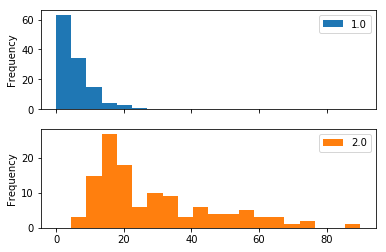

In [31]:
status = season.groupby('comp.live')['ensemble'].value_counts().unstack('comp.live').fillna(0)

status.plot.hist(bins=20, subplots=True)

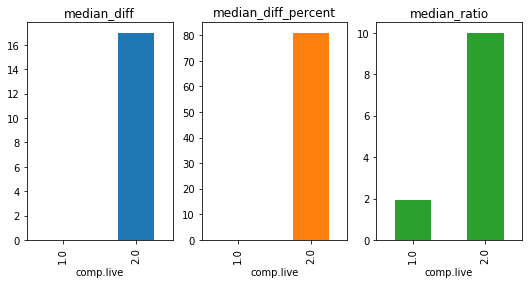

In [32]:
gap(status).iloc[:, :-1].plot.bar(subplots=True, layout=(1, 4), figsize=(12, 4), legend=False);

* Median performance gap between living and deceased composers: **17 (81%)**
* For every **10** orchestral performances of works by deceased composers, orchestras only perform **2** works by living composers
* No orchestras perform works by only living composers

In [33]:
# 2-tailed Wilcoxon test (non-parametric equivalence of t-test)
stats.wilcoxon(*status.values.transpose()).pvalue

8.150437263170644e-21

In [34]:
# effect size (non-parametric)
cliffs_delta(*status.values.transpose())

(-0.9331944444444444, 'negligible')

### By Demographics

In [35]:
demo = season.groupby(['comp.live', 'ensemble'])['comp.code'].value_counts().unstack(['comp.live', 'comp.code']).fillna(0)

#### Deceased Composers

Comparisons are made between white male composers and composers of other underrepresented groups (combined), due to white male being the overwhelmingly predominant demographic within the deceased composer category.

In [36]:
dead = demo[2].apply(lambda ens: [ens[1], ens[[2, 3, 4]].sum()], axis=1).apply(pd.Series)
dead.columns = ['white male', 'under-rep']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1362250f0>,
      dtype=object)

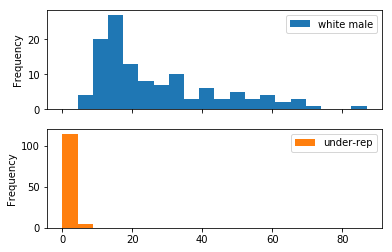

In [37]:
dead.plot.hist(bins=20, subplots=True)

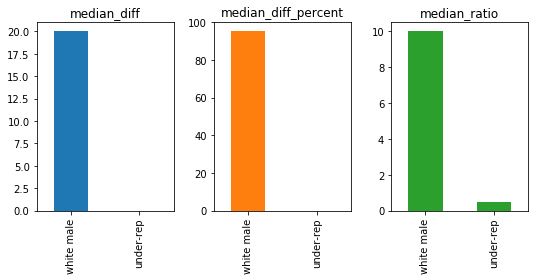

In [38]:
gap(dead).iloc[:, :-1].plot.bar(subplots=True, layout=(1, 4), figsize=(10, 4), legend=False)
plt.tight_layout()

* Median performance gap between white-male and underrepresented composers: **20 (95%)**
* For every **10** orchestral performances of works by white-male composers, orchestras only have **0.4** performances of works by underrepresented composers
* No orchestras perform works by only underrepresented composers

In [39]:
stats.wilcoxon(*dead.values.transpose()).pvalue

1.923647168792616e-21

In [40]:
cliffs_delta(*dead.values.transpose())

(0.9995833333333334, 'large')

#### Living Composers

Comparisons are made between all groups, between male and female, and between white and non-white composers.

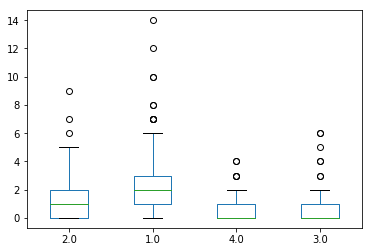

In [41]:
demo[1].plot.box()

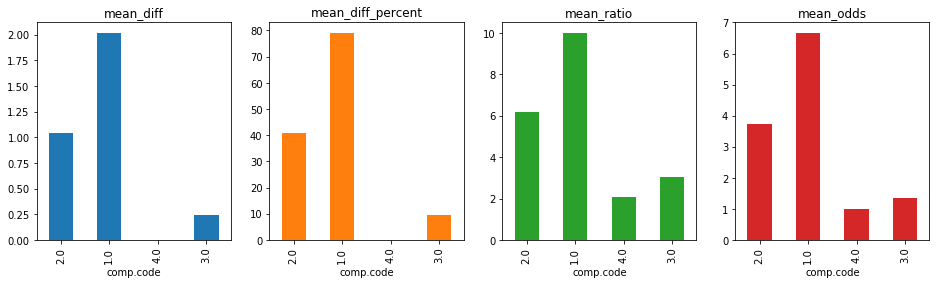

In [42]:
gap(demo[1], 'mean').plot.bar(subplots=True, layout=(1, 4), figsize=(16, 4), legend=False);

* Mean performance gap relative to non-white female composers
    * **2 (80%)** performances for white male composers
    * **1 (40%)** ... white female
    * **0.2 (9%)** ... non-white male
* For every **10** orchestral performances of works by white-male composers, orchestras only have
    * **6** performances of works by white female composers
    * **3** ... non-white male
    * **2** ... non-white female
* Compared to non-white female composers, orchestras are
    * **6.6** times more likely to perform works by white male composers
    * **3.7** ... white female
    * **1.3** ... non-white

In [43]:
# 1-way ANOVA (assuming equal Var), and Kruskal-Wallis H-test (non-parametric equivalence, does not assume equal Var)
stats.f_oneway(*demo[1].values.transpose()).pvalue, stats.kruskal(*demo[1].values.transpose()).pvalue

(3.733511846099344e-20, 8.365342827280307e-20)

In [44]:
[[(i, j), cliffs_delta(*demo[1][[i, j]].values.transpose())] for i in range(1, 5) for j in range(i + 1, 5)]

[[(1, 2), (0.22375, 'small')],
 [(1, 3), (0.5047222222222222, 'large')],
 [(1, 4), (0.5852777777777778, 'large')],
 [(2, 3), (0.3175, 'small')],
 [(2, 4), (0.41208333333333336, 'medium')],
 [(3, 4), (0.098125, 'negligible')]]

##### Gender Gap

In [45]:
gender = demo[1].apply(lambda ens: [ens[[1, 3]].sum(), ens[[2, 4]].sum()], axis=1).apply(pd.Series)
gender.columns = ['M', 'F']

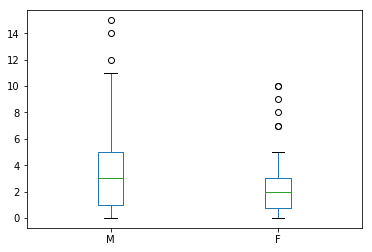

In [46]:
gender.plot.box()

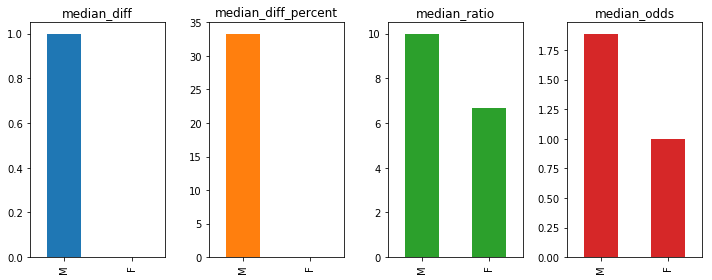

In [47]:
gap(gender).plot.bar(subplots=True, layout=(1, 4), figsize=(10, 4), legend=False);
plt.tight_layout()

* Median performance gap between male and female composers: **1 (33%)** performance
* For every **10** orchestral performances of works by male composers, orchestras only have **6.6** performances of works by female composers
* Orchestras are **1.8** times more likely to perform works by male composers than female composers

In [48]:
stats.wilcoxon(*gender.values.transpose()).pvalue

3.507379710041576e-06

In [49]:
cliffs_delta(*gender.values.transpose())

(0.25590277777777776, 'small')

##### Racial Identity Gap

In [50]:
race = demo[1].apply(lambda ens: [ens[[1, 2]].sum(), ens[[3, 4]].sum()], axis=1).apply(pd.Series)
race.columns = ['white', 'non-white']

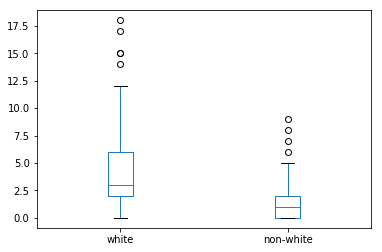

In [51]:
race.plot.box()

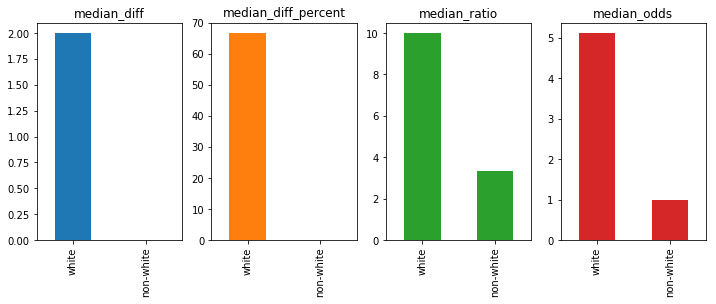

In [52]:
gap(race).plot.bar(subplots=True, layout=(1, 4), figsize=(12, 4), legend=False);

* Median performance gap between white and non-white composers: **2 (66%)** performance
* For every **10** orchestral performances of works by white composers, orchestras only have **3.3** performances of works by non-white composers
* Orchestras are **5.1** times more likely to perform works by white composers than non-white composers

In [53]:
stats.wilcoxon(*race.values.transpose()).pvalue

4.6733076951773154e-14

In [54]:
cliffs_delta(*race.values.transpose())

(0.5702083333333333, 'large')

# Notes & Thoughts